# Manhattan Taxi Demand Prediction

# Introduction

The New York City Taxi and Limousine Commission (TLC)¹ created in 1971, is the agency responsible for licensing and regulating New York City's medallion (yellow) taxis, and various other taxis. The yellow taxis are the most iconic taxis of NYC, which are widely recognized outside the USA too.

Yellow medallion taxis are traditionally hailed by signaling to a driver who is on duty and seeking a passenger (street hail), but now they may also be hailed using e-hail apps.

NYC has five boroughs  Bronx, Brooklyn, Manhattan, Queens, and Staten Island. The yellow taxis are the only vehicles permitted to respond to a street hail from a passenger in all five boroughs of NYC.

Here, I will try out few models to predict the demand for only yellow taxis and only in Manhattan. Manhattan is the busiest borough of NYC by a huge margin. I started out whole NYC yellow taxi data, but later I decided to create a model for only Manhattan. I will explain why in later part of this blog.

# Imports

In [2]:
# set the New York timezone so that the date parsing is correct
import os, time
os.environ['TZ'] = 'America/New_York'
time.tzset()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from joblib import dump, load
import xgboost as xgb
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Business Objectives and Constraints

i) Interpretability is not required. <br>
ii) We would want latency to be less than 2 seconds.<br>
iii) We would want less difference between actual and predicted demands.

# Data Acquisition

<p>We have collected the data from the official NYC site's TLC page¹. There you will find month and taxi type-wise data from the year 2009. 
    
<p>I have downloaded only for years 2018 and 2019. Now you might wonder why not 2020 data? That's because year 2020 had the covid pandemic, which disrupted everything. No machine learning model will work in such high uncertainty. 
    
<p>These types of events occur very very rarely (like once in a hundred years). In statistics, there is a term for this type of event, called the Black Swan event.
    
<p>The data on TLC page is very well detailed. There are many columns such as location id, pickup time, drop time, passenger count, trip cost, speed, etc. But for our problem, we will need only the location ID and the pickup time. So instead of downloading all the data, which will be huge for my mobile connection. I used Google colab as a medium to download only the relevant columns. 😎

In [ ]:
# Ran on Google Colab
'''
for year in tqdm([2019, 2018]):
    for month in range (1,13):
        gc.collect()
        filename = 'yellow_tripdata_'+str(year)+'-'+str(month).zfill(2)+'.csv'
        df=pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/'+filename, usecols=['tpep_pickup_datetime', 'PULocationID'])
        df.to_csv('gdrive/MyDrive/ML Backup/'+filename, index=False)
'''

# Data Formatting

The data were in different csv files for every month, so I combined them. I have used data from January 2018 and till April 2019 for training (training and cross-validation).

In [3]:
traindatas = []
for year in [2018, 2019]:
    for month in range (1,13):
        if year == 2018 or (year == 2019 and month <= 4):
            gc.collect()
            filename = 'yellow_tripdata_'+str(year)+'-'+str(month).zfill(2)+'.csv'
            traindatas.append(pd.read_csv('data/'+filename))
traindata = pd.concat(traindatas, ignore_index=True)
traindata.to_csv('traindata_.csv', index=False)

In [4]:
traindata.shape

(132757101, 2)

In [5]:
traindata.head()

,tpep_pickup_datetime,PULocationID
0,2018-01-01 00:21:05,41
1,2018-01-01 00:44:55,239
2,2018-01-01 00:08:26,262
3,2018-01-01 00:20:22,140
4,2018-01-01 00:09:18,246


In [6]:
traindata.tail()

,tpep_pickup_datetime,PULocationID
132757096,2019-04-30 23:26:25,237
132757097,2019-04-30 23:42:44,264
132757098,2019-04-30 22:18:51,239
132757099,2019-04-30 23:05:44,264
132757100,2019-04-30 23:07:48,193


In [7]:
traindata.PULocationID.isnull().sum()

0

In [21]:
len(traindata.PULocationID.unique())

264

In [9]:
np.sort(traindata.PULocationID.unique())

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

We have 132,757,101 pickups from 264 unique locations in this period of 16 months. The TLC has divided the whole NYC into 266 regions with location id ranging from 1 to 266.

In [10]:
traindata.tpep_pickup_datetime.isnull().sum()

0

<b>Applying some hack which will speed up generation of training data.</b>

In [4]:
year = []
month = []
day = []
timestamp = []
for date in tqdm(traindata.tpep_pickup_datetime.values):
    date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    year.append(date.year)
    month.append(date.month)    
    day.append(date.day)  
    timestamp.append(int(datetime.timestamp(date)))

100%|█████████████████████████| 132757101/132757101 [20:36<00:00, 107383.56it/s]


In [5]:
# converted datetime to timestamp
traindata['timestamp'] = traindata.tpep_pickup_datetime.apply(
                            lambda x: int(datetime.timestamp(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
                        )

In [9]:
# got the month number, which will help in filtering out data while counting
traindata['month'] = traindata.tpep_pickup_datetime.apply(
                        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month
                    )

In [10]:
# got the day number, which will help in filtering out data while counting
traindata['day'] = traindata.tpep_pickup_datetime.apply(
                        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day
                    )

In [15]:
traindata.drop(columns='tpep_pickup_datetime', inplace=True)

In [18]:
traindata.head()

,PULocationID,timestamp,month,day
0,41,1514784065,1,1
1,239,1514785495,1,1
2,262,1514783306,1,1
3,140,1514784022,1,1
4,246,1514783358,1,1


In [16]:
traindata.tail()

,PULocationID,timestamp,month,day
132757096,237,1556681185,4,30
132757097,264,1556682164,4,30
132757098,239,1556677131,4,30
132757099,264,1556679944,4,30
132757100,193,1556680068,4,30


In [17]:
# traindata.to_csv('traindata3.csv', index=False)

In [4]:
# traindata = pd.read_csv('traindata3.csv')

In [5]:
# we need to group by since we will be couting per location
traindataGrouped = traindata.groupby('PULocationID')

In [ ]:
data = []
i=0
# iterate for each locations
for group_name in tqdm(traindataGrouped.groups.keys()):   
    startdate = '2018-01-01 00:00:00';
    startdate = datetime.strptime(startdate, "%Y-%m-%d %H:%M:%S")
    tempdata = traindataGrouped.get_group(group_name)
    # iterate for each 15 minutes
    while startdate < datetime.strptime('2019-04-30 23:59:59', "%Y-%m-%d %H:%M:%S"):
        enddate = startdate + timedelta(minutes=15)
        startdate_timestamp = int(datetime.timestamp(startdate))
        enddate_timestamp = int(datetime.timestamp(enddate))
        month = startdate.month
        day = startdate.day
        # filter based on month and day
        tempdata1 = tempdata.loc[(tempdata['month']==month) & (tempdata['day']==day), ['timestamp']]
        # count number of pickups in given 15 minutes
        count = len(tempdata1.query('timestamp >= '+str(startdate_timestamp)+' ' \
                           + 'and timestamp < '+str(enddate_timestamp)))
        data.append((group_name, startdate_timestamp, count))
        # update startdate by 15 minutes
        startdate = enddate

In [31]:
traindata = pd.DataFrame(data, columns=['location', 'timestamp', 'counts'])

In [33]:
#data.to_csv('traindata4.csv', index=False)

In [ ]:
# traindata = pd.read_csv('traindata4.csv')

In [17]:
traindata.shape

(12289928, 3)

<p>The first timestamp 1514782800 corresponds to 2018–01–01 00:00 AM. And the second timestamp 1514783700 corresponds to 2018–01–01 00:15 AM and so on.
    
<p>Let's see how I calculated the counts. Let's take the first row for example. The location id is 1 and the timestamp is 1514782800. So I have counted the number of pickups from location id 1 between 2018–01–01 00:00 AM and 2018–01–01 00:14 AM. 
Similarly for the next row, I have counted the number of pickups from location id 1 between 2018–01–01 00:15 AM and 2018–01–01 00:29 AM.
    
<p><b>The location and the timestamp are input variables and the count is the output variable.</b> So the task is to predict the number of pickups in 15 minutes duration given a location id and time, which will be multiple of 15 minutes.

In [18]:
traindata.head()

,location,timestamp,counts
0,1,1514782800,0
1,1,1514783700,0
2,1,1514784600,0
3,1,1514785500,0
4,1,1514786400,0


In [19]:
traindata.tail()

,location,timestamp,counts
12293900,265,1556678700,3
12293901,265,1556679600,5
12293902,265,1556680500,1
12293903,265,1556681400,2
12293904,265,1556682300,2


# Business Metrics

1. We will use MAE (mean absolute error) as a primary performance measure.
2. With MAE we also need to check the average of the output. Why? Because MAE alone is not enough. 
   <br>Suppose someone says that the MAE is 10 then it is good if the average output is 100 or 500 (problem specific) but it is not good if the average output is 10.
3. We will also see MAE% which is MAE/avg(y) . Which combination of above two.
4. RMSE is also a good measure, which we will track.
5. I have also checked R² error for sanity check.

Note we have not used MAPE. Because we have lots of outputs as zero or very small. MAPE becomes very large if we have lots of outputs as zero.

# Data Cleaning

## Smoothing

The counts are very jagged. To make it sensible for the training we have to make it a little bit smoother.

In [6]:
x = traindata[traindata.location==4].counts.values[:100]

For smoothing, we have used counts of 5 time interval's (t0, t+1, t+2, t-1, t-2). The formula we have used is <b>x[t-2]\*.05 + x[t-1]\*.20 + x[t]\*.50 + x[t+1]\*.20 + x[t+2]\*.05</b>

In [7]:
def smoothing(x):
    n = len(x)
    r = []
    for i in range(n):
        if i==0:
            r.append(x[i]*.7 + x[i+1]*.3)
        elif i==1:
            r.append(x[i]*.6 + x[i+1]*.3 + x[i+2]*.1)
        elif i==n-1:
            r.append(x[i-1]*.3 + x[i]*.7)
        elif i==n-2:
            r.append(x[i-2]*.1 + x[i-1]*.3 + x[i]*.6)
        else:
            r.append(x[i-2]*.05 + x[i-1]*.2 + x[i]*.5 + x[i+1]*.2 + x[i+2]*.05)
    return np.round(np.array(r), 2)

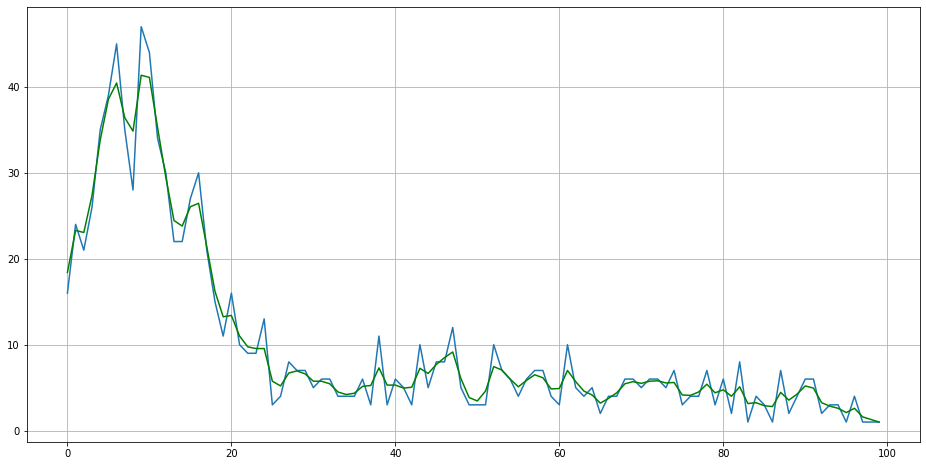

In [8]:
plt.figure(figsize=(16,8))
plt.plot(x)
plt.plot(smoothing(x), color='green')
plt.grid()
plt.show()

The blue line represents the original counts for a day. The green line represents the smoothed counts.

In [203]:
# there are some duplicates which need to be removed
traindata.drop_duplicates(subset={'location','timestamp'}, keep='first', inplace=True)

In [204]:
len(traindata.location.values)/len(traindata.location.unique())

46552.0

In [10]:
traindata.shape

(12289728, 3)

In [205]:
# already sorted a/c to location
np.all(traindata.location.values==np.sort(traindata.location.values))

True

In [11]:
x = []
for i in tqdm(np.sort(traindata.location.unique())):
    x.extend(smoothing(traindata[traindata.location == i]['counts'].values))

100%|█████████████████████████████████████████| 264/264 [01:51<00:00,  2.36it/s]


In [12]:
traindata['counts'] = x

We will do the smoothing only for the training data.

For testing, I will not perform smoothing just to get an idea of the real world's performance.

## Only for Manhattan

<p>We will use only the Manhattan data. Because Manhattan is a very busy city. And the data of Manhattan is very different from other areas because there are fewer pickups.
<p>In this case, instead of building a single model, we can create different models to get better performance. However, here I will create model for Manhattan only.

In [14]:
zones = pd.read_csv('taxi+_zone_lookup.csv')
manhattan_loc = zones[zones.Borough=='Manhattan'].LocationID.values

In [17]:
# Use only Manhattan data
traindata = traindata[traindata.location.isin(manhattan_loc)]

In [19]:
#traindata.to_csv('traindata5.csv', index=False)

In [20]:
traindata.location.unique()

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 104, 105, 107, 113, 114, 116, 120, 125,
       127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158,
       161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229,
       230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249,
       261, 262, 263])

In [21]:
len(traindata.location.unique())

68

We will use only the Manhattan data. Because Manhattan is a very busy city. And the data of Manhattan is very different from other areas because there are fewer pickups.<p>
Out of 132 million pickups, Manhattan has 120 million pickups. The other four boroughs have only 12 million pickups.<p>
In this case, instead of building a single model, we can create different models to get better performance. However, here I will create model for Manhattan only.<p>
In our training data, we have 68 locations that belong to Manhattan.

# Data Overview

In [18]:
traindata.shape

(3165536, 3)

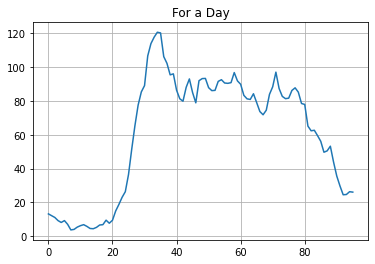

In [22]:
plt.title('For a Day')
plt.plot(traindata[traindata.location==141].counts.values[96:96*2])
plt.grid()
plt.show()

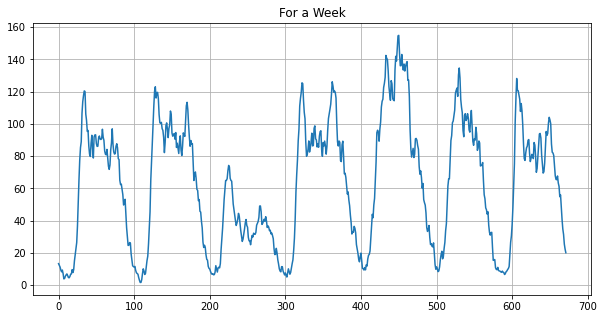

In [23]:
plt.figure(figsize=(10,5))
plt.title('For a Week')
plt.plot(traindata[traindata.location==141].counts.values[96:96*8])
plt.grid()
plt.show()

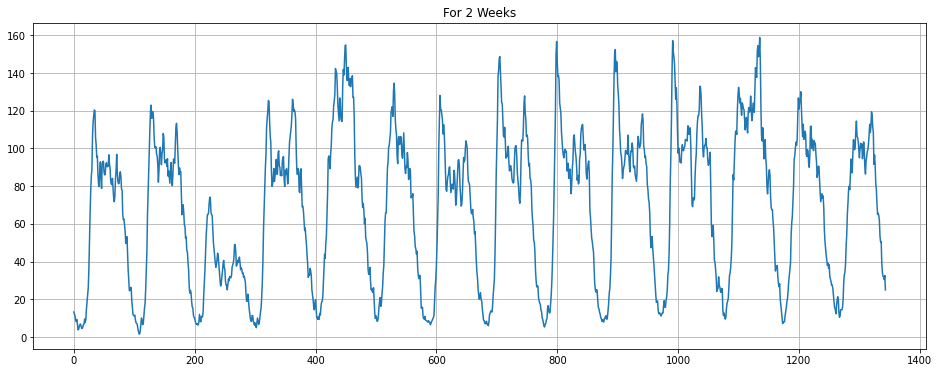

In [24]:
plt.figure(figsize=(16,6))
plt.title('For 2 Weeks')
plt.plot(traindata[traindata.location==141].counts.values[96:96*15])
plt.grid()
plt.show()

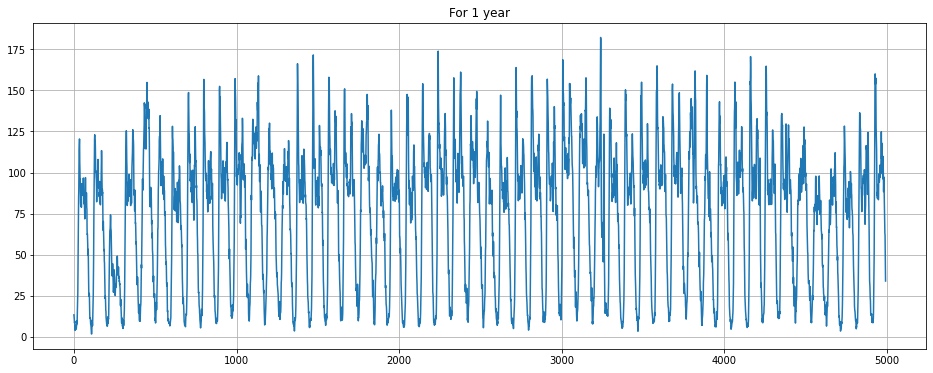

In [14]:
plt.figure(figsize=(16,6))
plt.title('For 1 year')
plt.plot(traindata[traindata.location==141].counts.values[96:96*53])
plt.grid()
plt.show()

In [4]:
# traindata =pd.read_csv('traindata5.csv')

In [7]:
traindata.counts.describe()

count    3.165536e+06
mean     3.801636e+01
std      4.674168e+01
min      0.000000e+00
25%      3.600000e+00
50%      1.880000e+01
75%      5.850000e+01
max      6.599000e+02
Name: counts, dtype: float64

In [8]:
traindata.counts.sum()

120342142.54999992

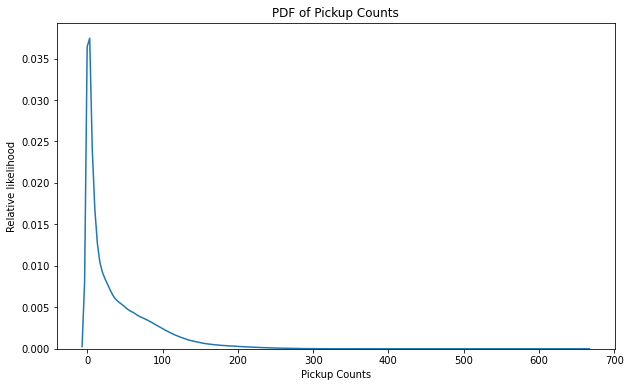

In [20]:
plt.figure(figsize=(10,6))
sns.kdeplot(traindata.counts)
plt.title('PDF of Pickup Counts')
plt.xlabel('Pickup Counts')
plt.ylabel('Relative likelihood')
plt.show()

In [27]:
np.set_printoptions(suppress=True)
{str(i*10)+'th' :v for i,v in enumerate(np.percentile(traindata.counts.values, range(0,101, 10)))}

{'0th': 0.0,
 '10th': 0.05,
 '20th': 2.2,
 '30th': 5.3,
 '40th': 10.25,
 '50th': 18.8,
 '60th': 31.05,
 '70th': 48.05,
 '80th': 70.5,
 '90th': 102.7,
 '100th': 659.9}

In [30]:
(traindata.counts.values==0).sum()

300955

In [31]:
(traindata.counts.values!=0).sum()

2864581

In [32]:
(traindata.counts.values==0).sum()/len(traindata.counts)

0.0950723668914206

In [21]:
(traindata.counts.values<1).sum()/len(traindata.counts)

0.15551552722824824

* We have two features, location and timestamp.
* Counts is the output label.
* We have 3,165,536 data points.
* We can certainly see a daily pattern.
* But I am surprised that we do not see any clear uptrend in a year.
* We have 120,342,142.55 pickups. It's in decimal because we have smoothed.
* We have a minimum of 0 pickups and a maximum of 659.9 pickups.
* Approx 9.50% of data points have counts=0 and approx 15.55% of data points have counts<1 out of the 3.165MM.
* 25% of the data have counts ≤ 3.6 and only 10% of the data have counts≥102.7.
* That pickup counts are highly skewed.

# Feature Extraction

At a given time we will have access to all previous data. <br>
Based on counts of previous time intervals we can create some very good features.

In [15]:
def feature1(data):
    pd.options.mode.chained_assignment = None
    t_1 = []
    t_2 = []
    t_3 = []
    t_4 = []
    t_5 = []

    d_0 = []
    d_1 = []
    d_2 = []
    d__1 = []
    d__2 = []
    for i in tqdm(np.sort(data.location.unique())):
        temp = data[data.location == i]
        for j in range(len(temp)):
            t_1_temp = 0
            t_2_temp = 0
            t_3_temp = 0
            t_4_temp = 0
            t_5_temp = 0

            if j>0:
                t_1_temp = temp.iloc[j-1].counts
            if j>1:
                t_2_temp = temp.iloc[j-2].counts
            if j>2:
                t_3_temp = temp.iloc[j-3].counts
            if j>3:
                t_4_temp = temp.iloc[j-4].counts
            if j>4:
                t_5_temp = temp.iloc[j-5].counts
            t_1.append(t_1_temp)
            t_2.append(t_2_temp)
            t_3.append(t_3_temp)
            t_4.append(t_4_temp)
            t_5.append(t_5_temp)

            d_0_temp = 0
            d_1_temp = 0
            d_2_temp = 0
            d__1_temp = 0
            d__2_temp = 0
            if j>93:
                d_2_temp = temp.iloc[j-94].counts
            if j>94:
                d_1_temp = temp.iloc[j-95].counts
            if j>95:
                d_0_temp = temp.iloc[j-96].counts
            if j>96:
                d__1_temp = temp.iloc[j-97].counts
            if j>97:
                d__2_temp = temp.iloc[j-98].counts
            d_0.append(d_0_temp)
            d_1.append(d_1_temp)
            d_2.append(d_2_temp)
            d__1.append(d__1_temp)
            d__2.append(d__2_temp)
    
    data['t-1'] = t_1
    data['t-2'] = t_2
    data['t-3'] = t_3
    data['t-4'] = t_4
    data['t-5'] = t_5

    data['dt0'] = d_0
    data['dt-1'] = d__1
    data['dt-2'] = d__2
    data['dt+1'] = d_1
    data['dt+2'] = d_2
    return data

In [133]:
traindata = feature1(traindata)

100%|███████████████████████████████████████████| 68/68 [41:18<00:00, 36.45s/it]


In [136]:
traindata.head(100)

,location,timestamp,counts,t-1,t-2,t-3,t-4,t-5,dt0,dt-1,dt-2,dt+1,dt+2
139656,4,1514782800,18.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
139657,4,1514783700,23.30,18.40,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
139658,4,1514784600,23.05,23.30,18.40,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
139659,4,1514785500,27.35,23.05,23.30,18.40,0.00,0.00,0.00,0.00,0.0,0.00,0.00
139660,4,1514786400,33.80,27.35,23.05,23.30,18.40,0.00,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139751,4,1514868300,2.10,2.60,2.85,3.25,4.95,5.20,0.00,0.00,0.0,18.40,23.30
139752,4,1514869200,2.60,2.10,2.60,2.85,3.25,4.95,18.40,0.00,0.0,23.30,23.05
139753,4,1514870100,1.60,2.60,2.10,2.60,2.85,3.25,23.30,18.40,0.0,23.05,27.35
139754,4,1514871000,1.10,1.60,2.60,2.10,2.60,2.85,23.05,23.30,18.4,27.35,33.80


* t-1: pickup counts at last time interval.
* t-2: pickup counts at second last time interval.
* t-3: pickup counts at third last time interval.
* t-4: pickup counts at fourth last time interval.
* t-5: pickup counts at fifth last time interval.
* dt0: pickup counts at same time on previous day.
* dt-1: pickup counts at t-1 time on previous day.
* dt-2: pickup counts at t-2 time on previous day.
* dt+1: pickup counts at t+1 time on previous day.
* dt+2: pickup counts at t+2 time on previous day.

In [16]:
def feature2(data):
    data['tdiff1'] = data.apply(lambda x:x['t-1']-x['t-2'], axis=1)
    data['tdiff2'] = data.apply(lambda x:x['t-2']-x['t-3'], axis=1)    
    data['tdiff3'] = data.apply(lambda x:x['t-3']-x['t-4'], axis=1)    
    data['tdiff4'] = data.apply(lambda x:x['t-4']-x['t-5'], axis=1)    
    
    data['ty1'] = data.apply(lambda x:x['t-1']-x['dt-1'], axis=1)    
    data['ty2'] = data.apply(lambda x:x['t-2']-x['dt-2'], axis=1)    
    
    data['avg_y'] = data.apply(lambda x:(x['dt-2']+x['dt-1']+x['dt0']+x['dt+1']+x['dt+2'])/5, axis=1)       
    return data

In [150]:
traindata = feature2(traindata)

In [153]:
traindata.head(100)

,location,timestamp,counts,t-1,t-2,t-3,t-4,t-5,dt0,dt-1,dt-2,dt+1,dt+2,tdiff1,tdiff2,tdiff3,tdiff4,ty1,ty2,avg_y
0,4,1514782800,18.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,4,1514783700,23.30,18.40,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,18.40,0.00,0.00,0.00,18.40,0.00,0.00
2,4,1514784600,23.05,23.30,18.40,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,4.90,18.40,0.00,0.00,23.30,18.40,0.00
3,4,1514785500,27.35,23.05,23.30,18.40,0.00,0.00,0.00,0.00,0.0,0.00,0.00,-0.25,4.90,18.40,0.00,23.05,23.30,0.00
4,4,1514786400,33.80,27.35,23.05,23.30,18.40,0.00,0.00,0.00,0.0,0.00,0.00,4.30,-0.25,4.90,18.40,27.35,23.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,1514868300,2.10,2.60,2.85,3.25,4.95,5.20,0.00,0.00,0.0,18.40,23.30,-0.25,-0.40,-1.70,-0.25,2.60,2.85,8.34
96,4,1514869200,2.60,2.10,2.60,2.85,3.25,4.95,18.40,0.00,0.0,23.30,23.05,-0.50,-0.25,-0.40,-1.70,2.10,2.60,12.95
97,4,1514870100,1.60,2.60,2.10,2.60,2.85,3.25,23.30,18.40,0.0,23.05,27.35,0.50,-0.50,-0.25,-0.40,-15.80,2.10,18.42
98,4,1514871000,1.10,1.60,2.60,2.10,2.60,2.85,23.05,23.30,18.4,27.35,33.80,-1.00,0.50,-0.50,-0.25,-21.70,-15.80,25.18


In [ ]:
#traindata.to_csv('traindata6.csv', index=False)

* tdiff1: which is equal to [t-1]-[t-2]
* tdiff2: which is equal to [t-2]-[t-3]
* tdiff3: which is equal to [t-3]-[t-4]
* tdiff4: which is equal to [t-4]-[t-5]
* ty1: which is equal to [t-1]-[dt-1]
* ty2: which is equal to [t-2]-[dt-2]
* avg_y: which is equal to ([dt-2]+[dt-1]+[dt0]+[dt+1]+[dt+2])/5

In [17]:
def feature3(data):
    n = 5
    
    data['simple_MA'] = data.apply(lambda x:(x['t-1']+x['t-2']+x['t-3']+x['t-4']+x['t-5'])/n, axis=1)
    
    data['weighted_MA'] = data.apply(lambda x:(n*x['t-1']+(n-1)*x['t-2']+(n-2)*x['t-3']+(n-3)*x['t-4']+(n-4)*x['t-5'])/(n*(n+1)/2), axis=1)
    
    alpha = 2/(1+n)
    data['exponential_MA'] = data.apply(lambda x:(alpha *  
                                  (x['t-1']+(1-alpha)*x['t-2']+((1-alpha)**2)*x['t-3']+((1-alpha)**3)*x['t-4']+((1-alpha)**4)*x['t-5'])), \
                                axis=1)       
    
    data['week_day'] = data.timestamp.apply(lambda x: datetime.fromtimestamp(x).isoweekday())
    return data

In [158]:
traindata = feature3(traindata)

In [167]:
traindata.head(100)

,location,timestamp,counts,t-1,t-2,t-3,t-4,t-5,dt0,dt-1,...,tdiff2,tdiff3,tdiff4,ty1,ty2,avg_y,simple_MA,weighted_MA,exponential_MA,week_day
0,4,1514782800,18.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,1
1,4,1514783700,23.30,18.40,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,18.40,0.00,0.00,3.68,6.133333,6.133333,1
2,4,1514784600,23.05,23.30,18.40,0.00,0.00,0.00,0.00,0.00,...,18.40,0.00,0.00,23.30,18.40,0.00,8.34,12.673333,11.855556,1
3,4,1514785500,27.35,23.05,23.30,18.40,0.00,0.00,0.00,0.00,...,4.90,18.40,0.00,23.05,23.30,0.00,12.95,17.576667,15.587037,1
4,4,1514786400,33.80,27.35,23.05,23.30,18.40,0.00,0.00,0.00,...,-0.25,4.90,18.40,27.35,23.05,0.00,18.42,22.376667,19.508025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,1514868300,2.10,2.60,2.85,3.25,4.95,5.20,0.00,0.00,...,-0.40,-1.70,-0.25,2.60,2.85,8.34,3.77,3.283333,2.812757,1
96,4,1514869200,2.60,2.10,2.60,2.85,3.25,4.95,18.40,0.00,...,-0.25,-0.40,-1.70,2.10,2.60,12.95,3.15,2.726667,2.346914,2
97,4,1514870100,1.60,2.60,2.10,2.60,2.85,3.25,23.30,18.40,...,-0.50,-0.25,-0.40,-15.80,2.10,18.42,2.68,2.543333,2.213992,2
98,4,1514871000,1.10,1.60,2.60,2.10,2.60,2.85,23.05,23.30,...,0.50,-0.50,-0.25,-21.70,-15.80,25.18,2.35,2.183333,1.866667,2


In [169]:
#traindata.to_csv('traindata7.csv', index=False)

* simple_MA: which is equal to ([t-5] + [t-4] + [t-3] + [t-2] + [t-1]) / 5
* weighted_MA: which is equal to (5\*[t-1] + 4\*[t-2] + 3\*[t-3] + 2\*[t-4] + 1\*[t-5]) / 15
* exponential_MA: which is equal to alpha \* { [t-1] + (1-alpha)\*[t-2] + ((1-alpha)²)\*x[t-3] + ((1-alpha)³)\*[t-4] + ((1-alpha)⁴)\*[t-5] } where alpha = 0.33
* week_day: Between 1 and 7 where it is 1 for Monday and 7 for Sunday.

We have created **21 new features**. So now we have **total of 23 features**.

# Data Pre-processing

First of all, we need to remove the data points for which some of the features could not be calculated. That means we have to remove the first 98 rows for each location.

In [175]:
# remove data points for which some of the features could not be caculated.
traindata = traindata.query('timestamp >= 1514871000')

In [176]:
traindata.shape

(3158872, 24)

In [177]:
#traindata.to_csv('traindata8.csv', index=False)

Then we need to create train and cross-validation data. Since there is a temporal nature. We can't do a random split. We need to divide it based on time.

We have used the whole 2018's data for training. And the first four months of 2019 as cross-validation data.

In [179]:
train = traindata.query('timestamp < 1546318800')

In [180]:
cv = traindata.query('timestamp >= 1546318800')

In [184]:
print(len(train))
print(len(train)/len(cv))

2375784
3.033865925668635


In [25]:
X_train = train.drop(columns=['counts']).to_numpy()

In [26]:
y_train = train['counts'].to_numpy()

In [27]:
X_cv = cv.drop(columns=['counts']).to_numpy()

In [28]:
y_cv = cv['counts'].to_numpy()

In [29]:
# with open('X_train.npy', 'wb') as f:
#     np.save(f, X_train, allow_pickle=True)
# with open('y_train.npy', 'wb') as f:
#     np.save(f, y_train, allow_pickle=True)
# with open('X_cv.npy', 'wb') as f:
#     np.save(f, X_cv, allow_pickle=True)
# with open('y_cv.npy', 'wb') as f:
#     np.save(f, y_cv, allow_pickle=True)

Note that I have not performed any normalization or standardization operation.

# Training

## Linear Regression

I trained a simple Linear Regression model without any regularization or hyper-param tuning.

In [70]:
model = LinearRegression()

In [71]:
model.fit(X_train, y_train)

LinearRegression()

In [72]:
y_pred = model.predict(X_cv)

In [76]:
np.average(y_cv)

34.75299212859857

In [93]:
print ('{:<25}'.format('MAPE with zeros => '), mean_absolute_percentage_error(np.round(y_cv), np.round(y_pred)))
print ('{:<25}'.format('MAPE without zeros => '), mean_absolute_percentage_error(y_cv[np.round(y_cv)!=0], y_pred[np.round(y_cv)!=0]))
print ('{:<25}'.format('MAE => '), mean_absolute_error(y_cv, y_pred))
print ('{:<25}'.format('MAE% => '), mean_absolute_error(y_cv, y_pred)/np.average(y_cv))
print ('{:<25}'.format('R squared => '), r2_score(y_cv, y_pred))
print ('{:<25}'.format('RMSE => '), mean_squared_error(y_cv, y_pred, squared=False))

MAPE with zeros =>        74085377888291.94
MAPE without zeros =>     0.13647757397815716
MAE =>                    2.2953657178141698
MAE% =>                   0.06604800269629996
R squared =>              0.9918960663612083
RMSE =>                   3.93240234243171


The MAPE on whole cross-validation data is absurd. It's in trillions. <br>
But if we calculate MAPE for only non-zero outputs, it's 0.1365. That's why we can not rely on MAPE if the actual outputs are zeros or very small values.<p>
The MAE is 2.23, to conclude whether it is good we need to know the average actual outputs. The average actual cv output is 34.75, which means the MAE is sensible. The MAE% is 6.60%, which is good. <p>
RMSE also looks good. And the R² is very close to 1.

In [94]:
list(features[np.argsort(np.abs(model.coef_))[::-1][:10]])

['tdiff1',
 't-1',
 'ty1',
 'dt-1',
 'exponential_MA',
 'weighted_MA',
 'week_day',
 'tdiff2',
 't-2',
 'simple_MA']

These are the top 10 important features for the Linear Regression model in descending order. All of them seem very intuitive.

In [82]:
# dump(model, 'LinearRegression.joblib') 

['LinearRegression.joblib']

## XGBoost Regressor

To tune the XGboost Regressor, I have used hyperopt which usage bayesian optimisation technique.

In [130]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    model = xgb.XGBRegressor(
                    objective = "reg:squarederror",
                    eval_metric = "mae",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = space['n_estimators'], 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                    reg_lambda = space['reg_lambda'],
                )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    mae = mean_absolute_error(y_cv, y_pred)
    print("MAE = " + str(mae))
    return{'loss':mae, 'status': STATUS_OK, 'model': model, 'params': space }

In [131]:
space = {
    'n_estimators' : hp.choice('n_estimators', [30, 50, 100, 150]),
    'max_depth' : hp.choice('max_depth', range(3, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01),
    "reg_lambda": hp.choice("reg_lambda", [10e-1, 10e0, 10e1])
}

In [139]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

MAE = 2.1861080964500945                                                        
MAE = 2.427236967800652                                                         
MAE = 2.280956279922865                                                         
MAE = 2.706358085010343                                                         
MAE = 2.2476748461558063                                                        
MAE = 2.2329497170745176                                                        
MAE = 2.1972972593635265                                                        
MAE = 2.8214913103704373                                                        
MAE = 2.2459322762994685                                                        
MAE = 2.2041174521900855                                                        
MAE = 2.2596493844827577                                                        
MAE = 2.4278022332078595                                                        
MAE = 2.2058584188619736    

In [146]:
trials.best_trial['result']['params']

{'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1.0}

After tuning I found the best hyper-parameters as {'learning_rate': 0.09, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1.0} which reduces the MAE to 2.15.

In [147]:
model = trials.best_trial['result']['model']

In [148]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, grow_policy='lossguide', importance_type='gain',
             interaction_constraints='', learning_rate=0.09, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1.0,
             scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=None)

In [149]:
y_pred = model.predict(X_cv)

In [150]:
np.average(y_cv)

34.75299212859857

In [151]:
print ('{:<25}'.format('MAPE with zeros => '), mean_absolute_percentage_error(np.round(y_cv), np.round(y_pred)))
print ('{:<25}'.format('MAPE without zeros => '), mean_absolute_percentage_error(y_cv[np.round(y_cv)!=0], y_pred[np.round(y_cv)!=0]))
print ('{:<25}'.format('MAE => '), mean_absolute_error(y_cv, y_pred))
print ('{:<25}'.format('MAE% => '), mean_absolute_error(y_cv, y_pred)/np.average(y_cv))
print ('{:<25}'.format('R squared => '), r2_score(y_cv, y_pred))
print ('{:<25}'.format('RMSE => '), mean_squared_error(y_cv, y_pred, squared=False))

MAPE with zeros =>        43420633679289.266
MAPE without zeros =>     0.1222785248643494
MAE =>                    2.153022961373042
MAE% =>                   0.06195216093641902
R squared =>              0.9926409973118548
RMSE =>                   3.7473088512663644


The performance is very similar to the previous model. There isn't any significant improvement.

In [152]:
# dump(model, 'XGBRegressor.joblib') 

['XGBRegressor.joblib']

In [155]:
list(features[np.argsort(np.abs(model.feature_importances_))[::-1][:10]])

['t-1',
 'tdiff1',
 'dt+2',
 't-5',
 'exponential_MA',
 'dt+1',
 'ty1',
 'simple_MA',
 'location',
 'week_day']

These are the top 10 important features for the XGBoost Regressor model in descending order. <p>
An interesting thing to note here is that t-5 is getting more importance than t-2, t-3, and t-4. <p>
The location feature in the top ten was also a surprise to me considering that we have more interesting features. But it's in there that means there is a difference in counts based on the location.

## LSTM (Long Short Term Memory)

When it comes to sequence of data, whether it is text data or time-series data. The LSTM has been the default choice. <p>
The LSTM is a deep learning model which is an improvement over the traditional RNN (Recurrent Neural Network). The RNN suffers from a short-term memory problem which was solved in LSTM.<p>
The LSTM will not use the traditional features that we have been using till now.<p>
For LSTM, we will provide the last 100 time interval's counts as input sequence. And hopefully, the LSTM will recognize the pattern. So we need to create new data.

### Featurization

In [3]:
# traindata = pd.read_csv('traindata7.csv')

In [5]:
def feature4(data):
    pd.options.mode.chained_assignment = None
    inp = []
    for i in tqdm(np.sort(data.location.unique())):
        temp = data[data.location == i]
        for j in range(len(temp)):
            inp_temp = temp.iloc[j-100:j].counts
            inp_temp
            inp.append(inp_temp)
    data['inp'] = inp
    return data

In [5]:
traindata = feature4(traindata)

100%|███████████████████████████████████████████| 68/68 [04:04<00:00,  3.59s/it]


In [3]:
# traindata = pd.read_csv('traindata9.csv')

In [12]:
traindata = traindata.query('timestamp >= 1514872800')

In [13]:
train = traindata.query('timestamp < 1546318800')

In [14]:
cv = traindata.query('timestamp >= 1546318800')

In [15]:
print(len(train))
print(len(cv))

2375648
783088


In [75]:
# new train data
X_train = []
for i in range(len(train)):
    X_train.append([train['inp'].iloc[i].to_list()])
X_train = np.array(X_train)
y_train = train['counts'].to_numpy()

In [83]:
# new cv data
X_cv = []
for i in range(len(cv)):
    X_cv.append([cv['inp'].iloc[i].to_list()])
X_cv = np.array(X_cv)
y_cv = cv['counts']

### Training LSTM

In [5]:
# to support GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

In [5]:
model = keras.Sequential()
model.add(keras.Input(shape=(1, 100)))
model.add(layers.LSTM(64, activation='relu', return_sequences=True))
model.add(layers.LSTM(64, activation='relu', return_sequences=False))
model.add(layers.Dense(1))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 75,329
Trainable params: 75,329
Non-trainable params: 0
_________________________________________________________________


We have two LSTM layers, one after another. Each has 64 ReLU activation units. The last layer is a dense layer with only one ReLU activation unit.

In [7]:
model.compile(
  loss='mean_absolute_error',
  optimizer=keras.optimizers.Adam()
)

In [8]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

I have used Adam optimizer which will minimize the MAE loss.<p>
I have also added an early stopping callback which will monitor the validation loss and will stop the training if it's not decreasing.

In [12]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_cv, y_cv),
                    callbacks=[callback],
                    shuffle=False,
                    batch_size=64)

2021-10-06 22:33:45.235021: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 950259200 exceeds 10% of free system memory.
2021-10-06 22:33:45.758472: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 950259200 exceeds 10% of free system memory.
2021-10-06 22:33:46.156723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
37120/37120 [==============================] - 196s 5ms/step - loss: 2.7157 - val_loss: 2.8321
Epoch 2/20
37120/37120 [==============================] - 195s 5ms/step - loss: 2.4982 - val_loss: 2.5859
Epoch 3/20
37120/37120 [==============================] - 159s 4ms/step - loss: 2.4528 - val_loss: 2.4293
Epoch 4/20
37120/37120 [==============================] - 159s 4ms/step - loss: 2.4448 - val_loss: 2.5737
Epoch 5/20
37120/37120 [==============================] - 173s 5ms/step - loss: 2.4350 - val_loss: 2.4016
Epoch 6/20
37120/37120 [==============================] - 208s 6ms/step - loss: 2.4201 - val_loss: 2.3561
Epoch 7/20
37120/37120 [==============================] - 189s 5ms/step - loss: 2.4329 - val_loss: 2.5015
Epoch 8/20
37120/37120 [==============================] - 157s 4ms/step - loss: 2.3939 - val_loss: 2.4736
Epoch 9/20
37120/37120 [==============================] - 158s 4ms/step - loss: 2.3978 - val_loss: 2.4855


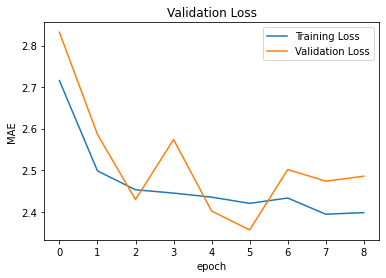

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()

After 9 epochs we converged to a sensible value.

In [13]:
y_pred = model.predict(X_cv)

In [14]:
np.average(y_cv)

34.75299212859857

In [15]:
print ('{:<25}'.format('MAPE with zeros => '), mean_absolute_percentage_error(np.round(y_cv), np.round(y_pred)))
print ('{:<25}'.format('MAPE without zeros => '), mean_absolute_percentage_error(y_cv[np.round(y_cv)!=0], y_pred[np.round(y_cv)!=0]))
print ('{:<25}'.format('MAE => '), mean_absolute_error(y_cv, y_pred))
print ('{:<25}'.format('MAE% => '), mean_absolute_error(y_cv, y_pred)/np.average(y_cv))
print ('{:<25}'.format('R squared => '), r2_score(y_cv, y_pred))
print ('{:<25}'.format('RMSE => '), mean_squared_error(y_cv, y_pred, squared=False))

MAPE with zeros =>        62272665096601.875
MAPE without zeros =>     0.14245882040187904
MAE =>                    2.3561169950788976
MAE% =>                   0.0677960903728927
R squared =>              0.9911530440567133
RMSE =>                   4.1087237303885145


The performance is worse than the other two models. We might be able to improve with more fine-tuning or increasing the sequence length.

In [22]:
# model.save('model.h5')

# Test Data Generation and Pre-processing

Till now we have used only the training data. For testing, we need to perform all the steps that we did earlier on raw test data as well. <p>
The raw test data is the data of last 8 months of 2019.<p>
In this section, I have performed all the data formatting, feature extraction, and featurization steps.

In [3]:
testdatas = []
for year in [2019]:
    for month in range (1,13):
        if month > 4:
            gc.collect()
            filename = 'yellow_tripdata_'+str(year)+'-'+str(month).zfill(2)+'.csv'
            testdatas.append(pd.read_csv('data/'+filename))
testdata = pd.concat(testdatas, ignore_index=True)
testdata.to_csv('testdata_.csv', index=False)

In [6]:
zones = pd.read_csv('taxi+_zone_lookup.csv')
manhattan_loc = zones[zones.Borough=='Manhattan'].LocationID.values
testdata = testdata[testdata.PULocationID.isin(manhattan_loc)]

In [7]:
year = []
month = []
day = []
timestamp = []
for date in tqdm(testdata.tpep_pickup_datetime.values):
    date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
    year.append(date.year)
    month.append(date.month)    
    day.append(date.day)  
    timestamp.append(int(datetime.timestamp(date)))
testdata['timestamp'] = testdata.tpep_pickup_datetime.apply(
                            lambda x: int(datetime.timestamp(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
                        )
testdata['month'] = testdata.tpep_pickup_datetime.apply(
                        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month
                    )
testdata['day'] = testdata.tpep_pickup_datetime.apply(
                        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day
                    )
testdata.drop(columns='tpep_pickup_datetime', inplace=True)

100%|███████████████████████████| 49289352/49289352 [07:35<00:00, 108091.77it/s]


In [3]:
#testdata = pd.read_csv('testdata3.csv')

In [8]:
testdataGrouped = testdata.groupby('PULocationID')

In [12]:
data = []
i=0
for group_name in tqdm(testdataGrouped.groups.keys()):   
    startdate = '2019-05-01 00:00:00';
    startdate = datetime.strptime(startdate, "%Y-%m-%d %H:%M:%S")
    tempdata = testdataGrouped.get_group(group_name)
    while startdate < datetime.strptime('2019-12-31 23:59:59', "%Y-%m-%d %H:%M:%S"):
        enddate = startdate + timedelta(minutes=15)
        startdate_timestamp = int(datetime.timestamp(startdate))
        enddate_timestamp = int(datetime.timestamp(enddate))
        month = startdate.month
        day = startdate.day
        tempdata1 = tempdata.loc[(tempdata['month']==month) & (tempdata['day']==day), ['timestamp']]
        count = len(tempdata1.query('timestamp >= '+str(startdate_timestamp)+' ' \
                           + 'and timestamp < '+str(enddate_timestamp)))
        data.append((group_name, startdate_timestamp, count))
        startdate = enddate

100%|█████████████████████████████████████████| 67/67 [1:25:56<00:00, 76.97s/it]


In [13]:
testdata = pd.DataFrame(data, columns=['location', 'timestamp', 'counts'])

In [20]:
testdata = feature1(testdata)

100%|███████████████████████████████████████████| 67/67 [17:00<00:00, 15.23s/it]


In [21]:
testdata = feature2(testdata)

In [22]:
testdata = feature3(testdata)

In [27]:
testdata = testdata.query('timestamp >= 1556771400')

In [28]:
testdata.shape

(1569274, 24)

In [29]:
# testdata.to_csv('testdata4.csv', index=False)

In [30]:
X_test = testdata.drop(columns=['counts']).to_numpy()

In [31]:
y_test = testdata['counts'].to_numpy()

In [33]:
# with open('X_test.npy', 'wb') as f:
#     np.save(f, X_test, allow_pickle=True)
# with open('y_test.npy', 'wb') as f:
#     np.save(f, y_test, allow_pickle=True)

In [3]:
testdata = pd.read_csv('testdata4.csv')

In [6]:
testdata = feature4(testdata)

100%|███████████████████████████████████████████| 67/67 [02:07<00:00,  1.91s/it]


In [13]:
testdata = testdata.query('timestamp >= 1556861400')

In [14]:
X_test = []
for i in range(len(testdata)):
    X_test.append([testdata['inp'].iloc[i].to_list()])
X_test = np.array(X_test)
y_test = testdata['counts'].to_numpy()

In [15]:
# with open('X_test_lstm.npy', 'wb') as f:
#     np.save(f, X_test, allow_pickle=True)
# with open('y_test_lstm.npy', 'wb') as f:
#     np.save(f, y_test, allow_pickle=True)

In [3]:
# with open('X_test.npy', 'rb') as f:
#     X_test = np.load(f, allow_pickle=True)
# with open('y_test.npy', 'rb') as f:
#     y_test = np.load(f, allow_pickle=True)

In [3]:
# with open('X_test_lstm.npy', 'rb') as f:
#     X_test = np.load(f, allow_pickle=True)
# with open('y_test_lstm.npy', 'rb') as f:
#     y_test = np.load(f, allow_pickle=True)

# Testing

Keep in mind that we have not done smoothing for the test data. So the performance on test data will certainly be worse than before.<p>
The average of output avg(y_test) is 31.25

## Linear Regression

In [4]:
lr_model = load('LinearRegression.joblib')

In [5]:
y_pred_lr = lr_model.predict(X_test)

In [7]:
np.average(y_test)

31.249874145624027

In [8]:
print ('{:<25}'.format('MAE => '), mean_absolute_error(y_test, y_pred_lr))
print ('{:<25}'.format('MAE% => '), mean_absolute_error(y_test, y_pred_lr)/np.average(y_test))
print ('{:<25}'.format('R squared => '), r2_score(y_test, y_pred_lr))
print ('{:<25}'.format('RMSE => '), mean_squared_error(y_test, y_pred_lr, squared=False))

MAE =>                    7.227731813183053
MAE% =>                   0.23128834949868637
R squared =>              0.9094240989153082
RMSE =>                   11.84154255439212


## XGBoost Regressor

In [9]:
xgb_model = load('XGBRegressor.joblib')

In [10]:
y_pred_xgb = xgb_model.predict(X_test)

In [11]:
np.average(y_test)

31.249874145624027

In [12]:
print ('{:<25}'.format('MAE => '), mean_absolute_error(y_test, y_pred_xgb))
print ('{:<25}'.format('MAE% => '), mean_absolute_error(y_test, y_pred_xgb)/np.average(y_test))
print ('{:<25}'.format('R squared => '), r2_score(y_test, y_pred_xgb))
print ('{:<25}'.format('RMSE => '), mean_squared_error(y_test, y_pred_xgb, squared=False))

MAE =>                    6.574487879610602
MAE% =>                   0.21038445943729467
R squared =>              0.9225697752186679
RMSE =>                   10.948565185380145


## LSTM 

In [6]:
lstm_model = keras.models.load_model('model.h5')

In [7]:
y_pred_lstm = lstm_model.predict(X_test)

2021-10-08 21:36:49.669100: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1250059200 exceeds 10% of free system memory.
2021-10-08 21:36:50.443780: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1250059200 exceeds 10% of free system memory.
2021-10-08 21:36:50.953808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
print ('{:<25}'.format('MAE => '), mean_absolute_error(y_test, y_pred_lstm))
print ('{:<25}'.format('MAE% => '), mean_absolute_error(y_test, y_pred_lstm)/np.average(y_test))
print ('{:<25}'.format('R squared => '), r2_score(y_test, y_pred_lstm))
print ('{:<25}'.format('RMSE => '), mean_squared_error(y_test, y_pred_lstm, squared=False))

MAE =>                    6.34815704342306
MAE% =>                   0.2033560382199119
R squared =>              0.92908681177385
RMSE =>                   10.465103391641659


The performance is significantly worse than before. But surprisingly LSTM is performing better than the other two models. This means the LSTM based model is more robust and is generalizing better than the others.

# Final Thoughts

We could tweak more to get better performance. Maybe try without smoothing or can come up with some new features. Or we can try stacking different models.<p>
Few interesting features that we could try are "is holiday or special day", "weather type", "season", "day or night", etc.<p>
Note that I have not used the classical time series forecasting models like Holt-Winters or ARIMA. Because on their own they will not perform as well as the current models. However, we can certainly get benefits from them if we do stacking ensembling.

# References

1. NYC Taxi and Limousine Commission (TLC) [https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page]
2. Applied Roots [https://www.appliedroots.com/]